In [1]:
import os
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white', {'xtick.bottom': True, 'ytick.left': True})
sns.set_context('notebook', font_scale=2)

%load_ext autoreload
%autoreload 2

os.chdir("../")

## Baseline with forward Euler

In [112]:
result_path = "RESULT/STPNet/STPNet_A_2.pkl"
# result_path = "RESULT/STPENet/STPENet_A_5.pkl"
temp = pickle.load(open(result_path, 'rb'))

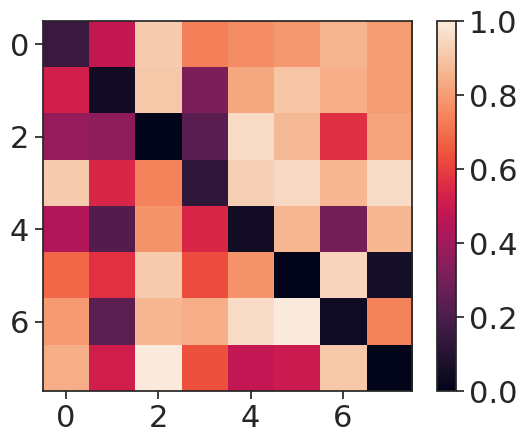

In [104]:
plt.imshow(temp['confusion_matrix'])
plt.colorbar()
plt.clim(0, 1)

In [113]:
model_data = temp
input_act = model_data['input']
hidden_act = model_data['hidden']
labels = model_data['labels']
image = model_data['image']

# find preferred image
img_idx = [np.argwhere(image==i) for i in range(8)]
input_act_image = [input_act[i[:,0], i[:,1]].mean(axis=0) for i in img_idx]
pref_image = np.argmax(np.stack(input_act_image), axis=0)

(128, 200)

In [106]:
batchind = 0

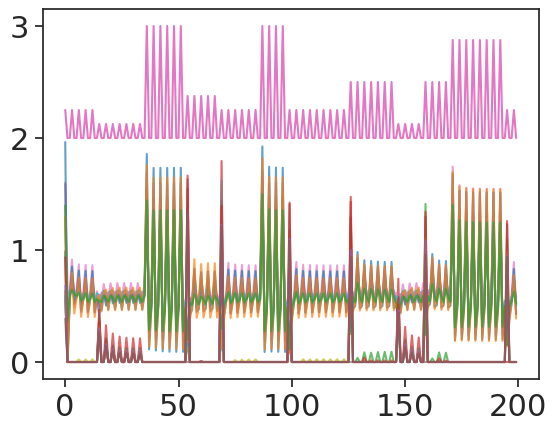

In [124]:
batchind += 1
plt.plot(hidden_act[batchind,:,:], alpha=0.7);
plt.plot(img_bs[batchind,:] / 8 + 2);

Text(0, 0.5, 'units')

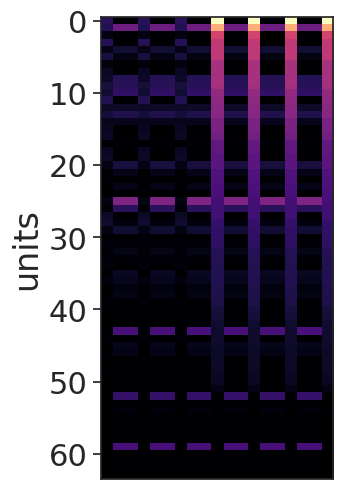

In [55]:
model_data = temp
input_act = model_data['input']
hidden_act = model_data['hidden']
labels = model_data['labels']
image = model_data['image']

# find preferred image
img_idx = [np.argwhere(image==i) for i in range(8)]
input_act_image = [input_act[i[:,0], i[:,1]].mean(axis=0) for i in img_idx]
pref_image = np.argmax(np.stack(input_act_image), axis=0)

# # find go trials
# idx = np.argwhere(labels.squeeze()==1)
# print(idx)

# go_trial = []
# for trial in idx:
#     trial_chunk = hidden_act[trial[0], (trial[1]-9):(trial[1]+9+1)]
#     if trial_chunk.shape[0] == 19:
#         go_trial.append(trial_chunk)
        
go_trial = np.zeros((input_act.shape[2], 19))
for cell in range(go_trial.shape[0]):
    idx = np.argwhere((labels.squeeze()==1)&(image==pref_image[cell]))
    go_trials = []
    for trial in idx:
        trial_chunk = input_act[trial[0], (trial[1]-9):(trial[1]+9+1), cell]
        if trial_chunk.shape[0] == go_trial.shape[1]:
            go_trials.append(trial_chunk)
    go_trial[cell,:] = np.stack(go_trials).mean(axis=0)

idx = np.argsort(go_trial[:,9])[::-1]

sns.set_style({'xtick.bottom': True, 'ytick.left': True,})
plt.figure(figsize=(3,6))
plt.imshow(go_trial[idx,:], vmin=0, vmax=go_trial[idx,:].max(), cmap='magma', aspect='auto')  # 0.75)  # input_act[0].transpose()[:, 12:], aspect='auto')
# plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))
plt.xticks([])
plt.ylabel('units')
# plt.xlabel('time after change (s)')

# plt.savefig('figures/example_stsp_population_response.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'a.u.')

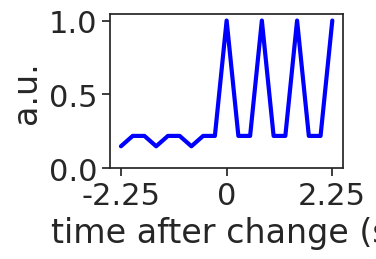

In [56]:
fig, ax = plt.subplots(figsize=(3,2))

# plt.plot(go_trial.mean(axis=0), color='blue', linewidth=3)
plt.plot(go_trial.mean(axis=0) / go_trial.mean(axis=0).max(), color='blue', linewidth=3)

plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))

ax.set_yticks([0, 0.5, 1.0])
# ax.set_ylim([0, 1.02])
ax.set_xlabel('time after change (s)')
ax.set_ylabel('a.u.')


## Baseline with backward Euler

In [49]:
result_path = "RESULT/STPNet/STPNet_A_4.pkl"
model_data = pickle.load(open(result_path, 'rb'))

Text(0, 0.5, 'units')

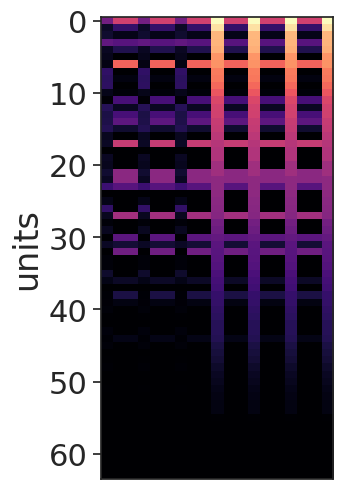

In [50]:
input_act = model_data['input']
hidden_act = model_data['hidden']
labels = model_data['labels']
image = model_data['image']

# find preferred image
img_idx = [np.argwhere(image==i) for i in range(8)]
input_act_image = [input_act[i[:,0], i[:,1]].mean(axis=0) for i in img_idx]
pref_image = np.argmax(np.stack(input_act_image), axis=0)

# # find go trials
# idx = np.argwhere(labels.squeeze()==1)

# go_trial = []
# for trial in idx:
#     trial_chunk = hidden_act[trial[0], (trial[1]-9):(trial[1]+9+1)]
#     if trial_chunk.shape[0] == 19:
#         go_trial.append(trial_chunk)
        
# go_trial = np.stack(go_trial).mean(axis=0).transpose()

go_trial = np.zeros((input_act.shape[2], 19))
for cell in range(go_trial.shape[0]):
    idx = np.argwhere((labels.squeeze()==1)&(image==pref_image[cell]))
    go_trials = []
    for trial in idx:
        trial_chunk = input_act[trial[0], (trial[1]-9):(trial[1]+9+1), cell]
        if trial_chunk.shape[0] == go_trial.shape[1]:
            go_trials.append(trial_chunk)
    go_trial[cell,:] = np.stack(go_trials).mean(axis=0)

idx = np.argsort(go_trial[:,9])[::-1]

sns.set_style({'xtick.bottom': True, 'ytick.left': True,})
plt.figure(figsize=(3,6))
plt.imshow(go_trial[idx,:], vmin=0, vmax=go_trial[idx,:].max(), cmap='magma', aspect='auto')  # 0.75)  # input_act[0].transpose()[:, 12:], aspect='auto')
# plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))
plt.xticks([])
plt.ylabel('units')
# plt.xlabel('time after change (s)')

# plt.savefig('figures/example_stsp_population_response.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'a.u.')

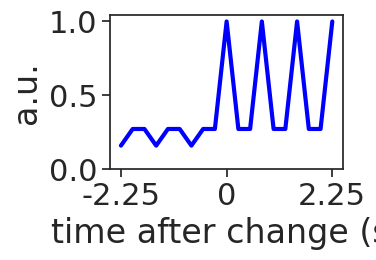

In [52]:
fig, ax = plt.subplots(figsize=(3,2))

# plt.plot(go_trial.mean(axis=0), color=colors[1], linewidth=3)
plt.plot(go_trial.mean(axis=0) / go_trial.mean(axis=0).max(), color='blue', linewidth=3)
plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))

ax.set_yticks([0, 0.5, 1.0])
# ax.set_ylim([0, 1.02])
ax.set_xlabel('time after change (s)')
ax.set_ylabel('a.u.')

## RNN

In [ ]:
result_path = "RESULT/RNN/RNN_A_4.pkl"
temp = pickle.load(open(result_path, 'rb'))

In [ ]:
plt.imshow(temp['confusion_matrix'])
plt.colorbar()
plt.clim(0, 1)

In [ ]:
model_data = temp
input_act = model_data['input']
hidden_act = model_data['hidden']
labels = model_data['labels']
image = model_data['image']

# find preferred image
img_idx = [np.argwhere(image==i) for i in range(8)]
input_act_image = [input_act[i[:,0], i[:,1]].mean(axis=0) for i in img_idx]
pref_image = np.argmax(np.stack(input_act_image), axis=0)

# # find go trials
# idx = np.argwhere(labels.squeeze()==1)

# go_trial = []
# for trial in idx:
#     trial_chunk = hidden_act[trial[0], (trial[1]-9):(trial[1]+9+1)]
#     if trial_chunk.shape[0] == 19:
#         go_trial.append(trial_chunk)
        
# go_trial = np.stack(go_trial).mean(axis=0).transpose()

go_trial = np.zeros((input_act.shape[2], 19))
for cell in range(go_trial.shape[0]):
    idx = np.argwhere((labels.squeeze()==1)&(image==pref_image[cell]))
    go_trials = []
    for trial in idx:
        trial_chunk = input_act[trial[0], (trial[1]-9):(trial[1]+9+1), cell]
        if trial_chunk.shape[0] == go_trial.shape[1]:
            go_trials.append(trial_chunk)
    go_trial[cell,:] = np.stack(go_trials).mean(axis=0)

idx = np.argsort(go_trial[:,9])[::-1]

sns.set_style({'xtick.bottom': True, 'ytick.left': True,})
plt.figure(figsize=(3,6))
plt.imshow(go_trial[idx,:], vmin=0, vmax=go_trial[idx,:].max(), cmap='magma', aspect='auto')  # 0.75)  # input_act[0].transpose()[:, 12:], aspect='auto')
# plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))
plt.xticks([])
plt.ylabel('units')
# plt.xlabel('time after change (s)')

# plt.savefig('figures/example_stsp_population_response.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(3,2))

# plt.plot(go_trial.mean(axis=0), color=colors[1], linewidth=3)
plt.plot(go_trial.mean(axis=0) / go_trial.mean(axis=0).max(), color='blue', linewidth=3)
plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))

ax.set_yticks([0, 0.5, 1.0])
ax.set_ylim([0, 1.02])
ax.set_xlabel('time after change (s)')
ax.set_ylabel('a.u.')


## STPNet with adaptation proportional to  *inverse* error

In [45]:
result_path = "RESULT/STPENet/STPENet_A_4.pkl"
temp = pickle.load(open(result_path, 'rb'))

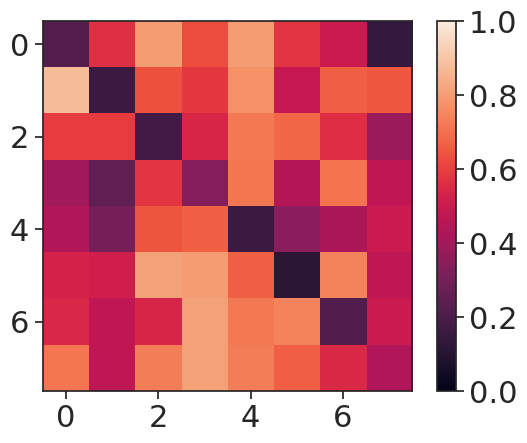

In [46]:
plt.imshow(temp['confusion_matrix'])
plt.colorbar()
plt.clim(0, 1)

Text(0, 0.5, 'units')

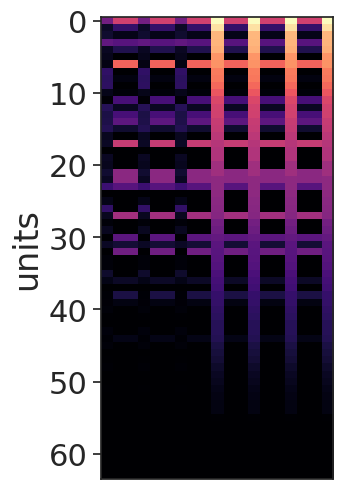

In [47]:
model_data = temp
input_act = model_data['input']
hidden_act = model_data['hidden']
labels = model_data['labels']
image = model_data['image']

# find preferred image
img_idx = [np.argwhere(image==i) for i in range(8)]
input_act_image = [input_act[i[:,0], i[:,1]].mean(axis=0) for i in img_idx]
pref_image = np.argmax(np.stack(input_act_image), axis=0)

# # find go trials
# idx = np.argwhere(labels.squeeze()==1)

# go_trial = []
# for trial in idx:
#     trial_chunk = hidden_act[trial[0], (trial[1]-9):(trial[1]+9+1)]
#     if trial_chunk.shape[0] == 19:
#         go_trial.append(trial_chunk)
        
# go_trial = np.stack(go_trial).mean(axis=0).transpose()

go_trial = np.zeros((input_act.shape[2], 19))
for cell in range(go_trial.shape[0]):
    idx = np.argwhere((labels.squeeze()==1)&(image==pref_image[cell]))
    go_trials = []
    for trial in idx:
        trial_chunk = input_act[trial[0], (trial[1]-9):(trial[1]+9+1), cell]
        if trial_chunk.shape[0] == go_trial.shape[1]:
            go_trials.append(trial_chunk)
    go_trial[cell,:] = np.stack(go_trials).mean(axis=0)

idx = np.argsort(go_trial[:,9])[::-1]

sns.set_style({'xtick.bottom': True, 'ytick.left': True,})
plt.figure(figsize=(3,6))
plt.imshow(go_trial[idx,:], vmin=0, vmax=go_trial[idx,:].max(), cmap='magma', aspect='auto')  # 0.75)  # input_act[0].transpose()[:, 12:], aspect='auto')
# plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))
plt.xticks([])
plt.ylabel('units')
# plt.xlabel('time after change (s)')

# plt.savefig('figures/example_stsp_population_response.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'a.u.')

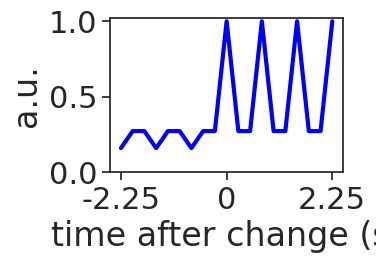

In [48]:
fig, ax = plt.subplots(figsize=(3,2))

# plt.plot(go_trial.mean(axis=0), color=colors[1], linewidth=3)
plt.plot(go_trial.mean(axis=0) / go_trial.mean(axis=0).max(), color='blue', linewidth=3)
plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))

ax.set_yticks([0, 0.5, 1.0])
ax.set_ylim([0, 1.02])
ax.set_xlabel('time after change (s)')
ax.set_ylabel('a.u.')


## STPNet with adaptation proportional to error

In [12]:
result_path = "RESULT/STPENet/STPENet_A_5.pkl"
temp = pickle.load(open(result_path, 'rb'))

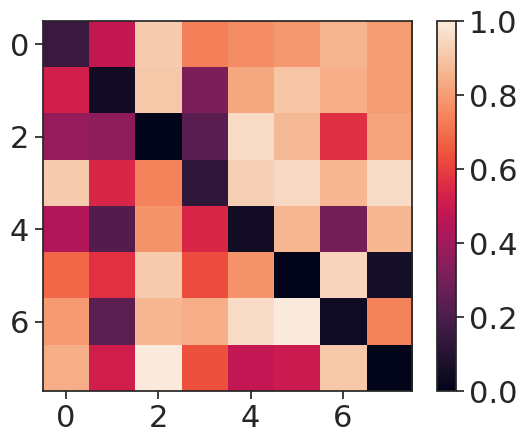

In [13]:
plt.imshow(temp['confusion_matrix'])
plt.colorbar()
plt.clim(0, 1)

Text(0, 0.5, 'units')

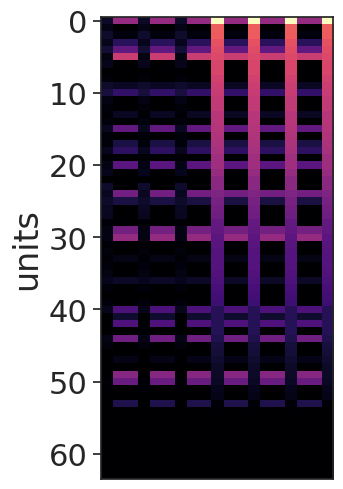

In [14]:
model_data = temp
input_act = model_data['input']
hidden_act = model_data['hidden']
labels = model_data['labels']
image = model_data['image']

# find preferred image
img_idx = [np.argwhere(image==i) for i in range(8)]
input_act_image = [input_act[i[:,0], i[:,1]].mean(axis=0) for i in img_idx]
pref_image = np.argmax(np.stack(input_act_image), axis=0)

# # find go trials
# idx = np.argwhere(labels.squeeze()==1)

# go_trial = []
# for trial in idx:
#     trial_chunk = hidden_act[trial[0], (trial[1]-9):(trial[1]+9+1)]
#     if trial_chunk.shape[0] == 19:
#         go_trial.append(trial_chunk)
        
# go_trial = np.stack(go_trial).mean(axis=0).transpose()

go_trial = np.zeros((input_act.shape[2], 19))
for cell in range(go_trial.shape[0]):
    idx = np.argwhere((labels.squeeze()==1)&(image==pref_image[cell]))
    go_trials = []
    for trial in idx:
        trial_chunk = input_act[trial[0], (trial[1]-9):(trial[1]+9+1), cell]
        if trial_chunk.shape[0] == go_trial.shape[1]:
            go_trials.append(trial_chunk)
    go_trial[cell,:] = np.stack(go_trials).mean(axis=0)

idx = np.argsort(go_trial[:,9])[::-1]

sns.set_style({'xtick.bottom': True, 'ytick.left': True,})
plt.figure(figsize=(3,6))
plt.imshow(go_trial[idx,:], vmin=0, vmax=go_trial[idx,:].max(), cmap='magma', aspect='auto')  # 0.75)  # input_act[0].transpose()[:, 12:], aspect='auto')
# plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))
plt.xticks([])
plt.ylabel('units')
# plt.xlabel('time after change (s)')

# plt.savefig('figures/example_stsp_population_response.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'a.u.')

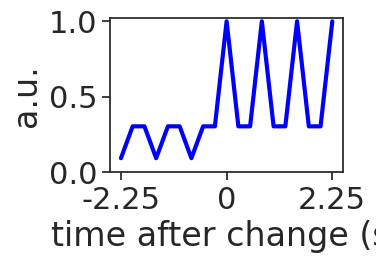

In [15]:
fig, ax = plt.subplots(figsize=(3,2))

# plt.plot(go_trial.mean(axis=0), color=colors[1], linewidth=3)
plt.plot(go_trial.mean(axis=0) / go_trial.mean(axis=0).max(), color='blue', linewidth=3)
plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))

ax.set_yticks([0, 0.5, 1.0])
ax.set_ylim([0, 1.02])
ax.set_xlabel('time after change (s)')
ax.set_ylabel('a.u.')


## Pred Err RNN

In [ ]:
temp_path = "RESULT/STPENet/STPENet_A_3.pkl"
model_data = pickle.load(open(temp_path, 'rb'))

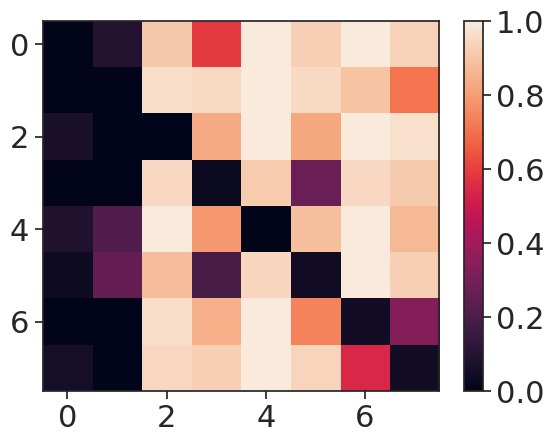

In [6]:
plt.imshow(model_data['confusion_matrix'], aspect="auto")
plt.colorbar()
plt.clim(0, 1)

Text(0, 0.5, 'units')

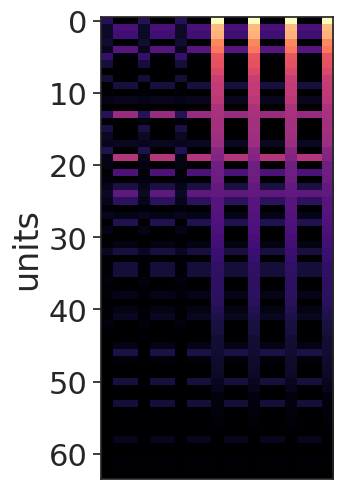

In [4]:
input_act = model_data['input']
hidden_act = model_data['hidden']
labels = model_data['labels']
image = model_data['image']

# find preferred image
img_idx = [np.argwhere(image==i) for i in range(8)]
input_act_image = [input_act[i[:,0], i[:,1]].mean(axis=0) for i in img_idx]
pref_image = np.argmax(np.stack(input_act_image), axis=0)

# # find go trials
# idx = np.argwhere(labels.squeeze()==1)

# go_trial = []
# for trial in idx:
#     trial_chunk = hidden_act[trial[0], (trial[1]-9):(trial[1]+9+1)]
#     if trial_chunk.shape[0] == 19:
#         go_trial.append(trial_chunk)
        
# go_trial = np.stack(go_trial).mean(axis=0).transpose()

go_trial = np.zeros((input_act.shape[2], 19))
for cell in range(go_trial.shape[0]):
    idx = np.argwhere((labels.squeeze()==1)&(image==pref_image[cell]))
    go_trials = []
    for trial in idx:
        trial_chunk = input_act[trial[0], (trial[1]-9):(trial[1]+9+1), cell]
        if trial_chunk.shape[0] == go_trial.shape[1]:
            go_trials.append(trial_chunk)
    go_trial[cell,:] = np.stack(go_trials).mean(axis=0)

idx = np.argsort(go_trial[:,9])[::-1]

sns.set_style({'xtick.bottom': True, 'ytick.left': True,})
plt.figure(figsize=(3,6))
plt.imshow(go_trial[idx,:], vmin=0, vmax=go_trial[idx,:].max(), cmap='magma', aspect='auto')  # 0.75)  # input_act[0].transpose()[:, 12:], aspect='auto')
# plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))
plt.xticks([])
plt.ylabel('units')
# plt.xlabel('time after change (s)')

# plt.savefig('figures/example_stsp_population_response.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'a.u.')

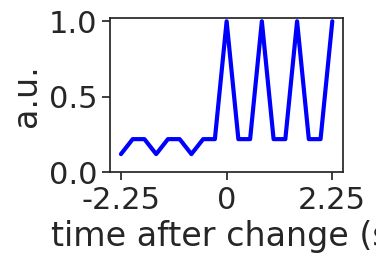

In [5]:
fig, ax = plt.subplots(figsize=(3,2))

# plt.plot(go_trial.mean(axis=0), color=colors[1], linewidth=3)
plt.plot(go_trial.mean(axis=0) / go_trial.mean(axis=0).max(), color='blue', linewidth=3)
plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))

ax.set_yticks([0, 0.5, 1.0])
ax.set_ylim([0, 1.02])
ax.set_xlabel('time after change (s)')
ax.set_ylabel('a.u.')
